## Just for Colab

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.6MB/s 


In [ ]:
id = '1ys_lSuLz4W-w5bEFqIqkp5CTy-eHUsZz'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('drugsComTest_raw.tsv')

id = '1otGdmfp9fRpM_Kni6Id_P9CDtBwbOZ7-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('drugsComTrain_raw.tsv')

id = '1hoAWqe9FH7CQuButSb_o4bl34Wmg4QyZ'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('PMC-w2v.bin')

id = '15k5iFAZC-P8uZLAKld23zCtfb9SYGQSK'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('GoogleNews-vectors-negative300.bin')

## Imports

In [ ]:
# please add all your imports here on the top, s.t. we have an easier time creating 
# the env yaml in the end. 
import pandas as pd
import numpy as np
from textblob import TextBlob # sentiment analysis 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import SGDRegressor


import pickle
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from nltk.stem import PorterStemmer


from gensim.models import KeyedVectors
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout, Masking, Embedding, Input, Concatenate
from keras import optimizers

import datetime
import json
import os
import pprint
import random
import sys
import tensorflow as tf
import html

import collections
from tensorflow.python.ops import math_ops
import pickle

In [ ]:
train = pd.read_csv('drugsComTrain_raw.tsv', sep='\t', header=0, engine='python', error_bad_lines=False)
train = train.rename(columns={'Unnamed: 0': 'Id'})
train = train.set_index('Id')

test = pd.read_csv('drugsComTest_raw.tsv', sep='\t', header=0, engine='python', error_bad_lines=False)
test = test.rename(columns={'Unnamed: 0': 'Id'})
test = test.set_index('Id')

In [ ]:
X_train = train.loc[:, train.columns != "rating"]
y_train = train.loc[:, "rating"]

X_test = test.loc[:, test.columns != "rating"]
y_test = test.loc[:,"rating"]

In [ ]:
def labelencode(y):
  # encoding based on task description
  
  y_res = np.zeros(y.shape[0])
  print(y_res.sum())
  y_res[y >= 4] = 1
  print(y_res.sum())
  y_res[y >= 7] = 2
  print(y_res.sum())
  return y_res

y_train_rating = y_train
y_test_rating = y_test
y_train = labelencode(y_train)
y_test = labelencode(y_test)

0.0
126234.0
233100.0
0.0
41928.0
77368.0


Note that there is class imbalance:

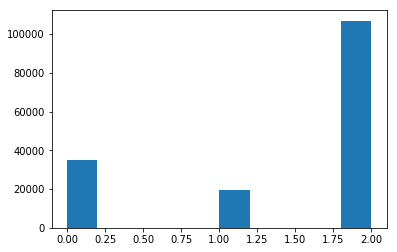

In [ ]:
plt.hist(y_train)
plt.show()

For the ratings we get the following distribution.

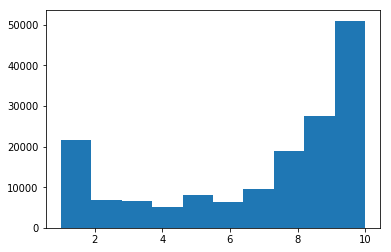

In [ ]:
plt.hist(y_train_rating)
plt.show()

## Helpers

In [ ]:
def myrow_concatenator(r):
  "concatenates texts from a row of a matrix"
  totalstr = ''
  for elem in r:
    if elem == elem: # doesn't hold for nans
      totalstr = totalstr + " " + elem 
  return totalstr

In [ ]:
def fit_randomforest(xtrain, ytrain, xval, yval, training_scores=False):
  if training_scores:
    xval = xtrain
    yval = ytrain

  #Random Forest
  print("\nRandom Forest")
  depths = [None, 10, 20, 30, 50, 100, 150]
  for d in depths:

      clf = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=42)
      clf.fit(xtrain, ytrain)
      pred_val = clf.predict(xval)

      f1 = f1_score(yval, pred_val, average='macro')
      acc = accuracy_score(yval, pred_val)

      print("For Depth: {}, F1 score: {:.2f}, Accuracy: {:.2f}".format(d, f1, acc))

In [ ]:
def fit_rf_regression(xtrain, ytrain, xval, yval):
  print("\nRandom Forest")
  depths = [None, 10, 20, 30, 50, 100, 150]
  for d in depths:
    clf = RandomForestRegressor(n_estimators=10, max_depth=d, random_state=42)
    clf.fit(xtrain, ytrain)
    pred_val = clf.predict(xval)
    mse = mean_squared_error(yval, pred_val)

    print("For Depth: {}, MSE: {:.2f}".format(d, mse))

## Preprocessing

### Feature selection

In [ ]:
X_train.head()

,drugName,condition,review,date,usefulCount
Id,,,,,
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...","May 20, 2012",27
95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...","April 27, 2010",192
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...","December 14, 2009",17
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...","November 3, 2015",10
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...","November 27, 2016",37


We assume that the date has only a marginal influence on the rating,  thus we drop the column.

In [ ]:
X_train.drop(columns=['date'], inplace=True)
X_test.drop(columns=['date'], inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### NA inspection & handling

In [ ]:
print(X_train.isna().sum())
print(X_test.isna().sum())
X_train
# condition is categorical

drugName         0
condition      899
review           0
usefulCount      0
dtype: int64
drugName         0
condition      295
review           0
usefulCount      0
dtype: int64


,drugName,condition,review,usefulCount
Id,,,,
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",27
95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",192
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",17
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",10
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",37
155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",43
165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",5
102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",32
74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",11


In this dataset the only NAs appear in 'condition'. This variable is categorical, so we can just one hot encode the categoricals as usual. This will have the effect that the NAs get treated as a category, which is what we want.

In [ ]:
print((X_train == '?').sum())
print((X_test == '?').sum())
print((X_train == 'Not Available').sum())
print((X_test == 'Not Available').sum())

drugName       0
condition      0
review         0
usefulCount    0
dtype: int64
drugName       0
condition      0
review         0
usefulCount    0
dtype: int64
drugName       0
condition      0
review         0
usefulCount    0
dtype: int64
drugName       0
condition      0
review         0
usefulCount    0
dtype: int64


In [ ]:
# inspect types of variables to encode them right
for col in X_train.columns:
  if col == "review": continue
  print(f"unique values of {col}:")
  vals = X_train.loc[:,col].values
  print(np.unique(vals.astype('str')))
  print("\n")
  
'''
drugname: just the name of the drug, we could kick it out (we have the id)
condition: categorical, lets kick out 'i</span> users found this comment helpful.'
review: text
date: date
useful count: nr
'''

unique values of drugName:
['A + D Cracked Skin Relief' 'A / B Otic'
 'Abacavir / dolutegravir / lamivudine' ... 'depo-subQ provera 104' 'ella'
 'femhrt']


unique values of condition:
['0</span> users found this comment helpful.'
 '10</span> users found this comment helpful.'
 '110</span> users found this comment helpful.'
 '11</span> users found this comment helpful.'
 '121</span> users found this comment helpful.'
 '123</span> users found this comment helpful.'
 '12</span> users found this comment helpful.'
 '13</span> users found this comment helpful.'
 '142</span> users found this comment helpful.'
 '145</span> users found this comment helpful.'
 '146</span> users found this comment helpful.'
 '14</span> users found this comment helpful.'
 '15</span> users found this comment helpful.'
 '16</span> users found this comment helpful.'
 '17</span> users found this comment helpful.'
 '18</span> users found this comment helpful.'
 '19</span> users found this comment helpful.'
 '1</span> 

"\ndrugname: just the name of the drug, we could kick it out (we have the id)\ncondition: categorical, lets kick out 'i</span> users found this comment helpful.'\nreview: text\ndate: date\nuseful count: nr\n"

We see that there are erroneous entries in condition, therefore we set them to nan.

In [ ]:
to_delete = X_train['condition'].str.endswith('users found this comment helpful.')
to_delete[to_delete.isna()] = False
to_delete.sum()

900

In [ ]:
X_train.loc[to_delete, 'condition'] = np.nan

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
X_train.loc[to_delete].head()

,drugName,condition,review,usefulCount
Id,,,,
220696,Loestrin 24 Fe,NaN,"""I&#039;m 16 and I have been on Loestrin 24 f...",2
67383,Provera,NaN,"""I&#039;m 24 years old and have always had a p...",4
81588,Yaz,NaN,"""I took Yaz for a little over 2 years. From a...",3
132965,Loestrin 24 Fe,NaN,"""Took this pill for 1.) Acne and 2.) Birth Con...",4
91050,Norco,NaN,"""I have suffered with low back pain - 2 surger...",11


In [ ]:
to_delete = X_test['condition'].str.endswith('users found this comment helpful.')
to_delete[to_delete.isna()] = False
X_test.loc[to_delete, 'condition'] = np.nan

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
X_train['condition'].unique().shape[0]

812

In [ ]:
X_train['drugName'].unique().shape[0]

3436

### Cleaning Text columns

Before working with the text features, we preprocess the text, in particular we convert it to lowercase and remove punctuation and digits. 

In [ ]:
class Preprocessing():
  
  def __init__(self, X, cols, stop_words):
    self.X = X
    self.cols = cols
    self.stop_words = stop_words
    self.clean_vec = np.vectorize(self.clean)
  
  
  def unique_names(self, names, col):
    global drugs
    global conditions
    
    if col == "drugName":
      drugs.update(set(names))
    elif col == "condition":
      conditions.update(set(names))
      
  
  def clean(self,textinp, col):
    # makes text lowercase, removes punctuations and digits
    text = textinp.lower()
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = text.translate(str.maketrans(string.digits, ' '*len(string.digits)))
#     text = re.sub(r'[\t|\n|/]', r' ', text) #removing tab spaces and new lines
    
#     print(text)
    # Tokenizing and removing stop words
    word_tokens = word_tokenize(text)
    clean_text = []  
    
    for word in word_tokens:
      if word not in self.stop_words:
        clean_text.append(word)
    
    
    self.unique_names(clean_text, col)
    
    return " ".join(clean_text)
  
  
  def apply_clean_to_cell(self):
    
    
    X_res = (self.X).copy()
    
    for col in self.cols:
      X_res.loc[:,col] = self.clean_vec((self.X).loc[:,col], col)
    
    return X_res
      

In [ ]:
drugs = set()
conditions = set()
X_train['condition'].fillna('', inplace= True)
X_test['condition'].fillna('', inplace= True)
stop_words = set(stopwords.words('english'))
text_cols = ["drugName", "condition", "review"]
# med_cols = ["drugName", "condition"]

X_train_clean = Preprocessing(X_train, text_cols, stop_words).apply_clean_to_cell()
X_test_clean = Preprocessing(X_test, text_cols, stop_words).apply_clean_to_cell()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [ ]:
# Saving the all durgs and conditions for faster access

with open('Drugs', 'wb') as fd:
  pickle.dump(drugs, fd)

with open('Conditions', 'wb') as fc:
  pickle.dump(conditions, fc)

In [ ]:
# Storing the list of drugs and conditions
with open('Drugs', 'wb') as fd:
  pickle.dump(drugs, fd)

with open('Conditions', 'wb') as fc:
  pickle.dump(conditions, fc)

### Vectorizing all drugs and conditions

In [ ]:
pmc_map = KeyedVectors.load_word2vec_format('PMC-w2v.bin', binary=True)

In [ ]:
Drugs_not_found = []
drug_map = {}

for drug in drugs:
  try:
    drug_map[drug] = pmc_map[drug]
  except:
    Drugs_not_found.append(drug)

In [ ]:
print(f'Found {len(drug_map)} drugs mapping out of {len(drugs)}' )

In [ ]:
Conditions_not_found = []
condition_map = {}

for cond in conditions:
  try:
    condition_map[cond] = pmc_map[cond]
  except:
    Conditions_not_found.append(cond)
  

In [ ]:
print(f'Found {len(condition_map)} conditions mapping out of {len(conditions)} conditions')

## Train Validation Split

We split the training set into a 80-20 train-validation split.

In [ ]:
X_train_clean_unsplit = X_train_clean
y_train_unsplit = y_train
y_train_rating_unsplit = y_train_rating

X_train_clean, X_val_clean, y_train, y_val = train_test_split(X_train_clean_unsplit, y_train_unsplit, test_size=0.2, random_state=42)
X_train_clean, X_val_clean, y_train_rating, y_val_rating = train_test_split(X_train_clean_unsplit, y_train_rating_unsplit, test_size=0.2, random_state=42)


## Lemmatization & Stemming

Quick recap from https://stackoverflow.com/questions/1787110/what-is-the-true-difference-between-lemmatization-vs-stemming:

    The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

    However, the two words differ in their flavor. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

Using e.g. Lemmatization can thus help in the sentiment analysis because slightly different words that mean the same get canonized. Concretely this can be useful for building bag of word models or TFIDF matrices, where without lemmatization/stemming words/typos like 'without' or 'withouts', 'withoutv' get counted & treated individually.

In [ ]:
nlpspacy = spacy.load('en', disable=['parser', 'ner'])
ps = PorterStemmer()

def lemmatize_text(text):
  # spacys lemmatizer superior to nltk or textblobs because it correctly handles verbs and pronouns 
  # without needing the appropriate POS tag as input
  return " ".join([token.lemma_ for token in nlpspacy(str(text))])

def stem_text(text):
  return " ".join([ps.stem(word) for word in word_tokenize(text)])

def add_per_cell_text_features(X, textcolumns, toapplyfunc, colname):
  to_transform = X.loc[:,textcolumns].values
  if to_transform.size > to_transform.shape[0]: # add all texts for one sample to one text  
    to_transform = np.apply_along_axis(myrow_concatenator, 1, to_transform) 
  n = to_transform.shape[0]
  result_texts = ['']*n

  for idx, text in enumerate(to_transform):
    result_texts[idx] = toapplyfunc(text)
    if idx % 1000 == 0:
      print(f"{idx}/{n} = {np.round(100*idx/n,1)}% done")
  transformed_df = pd.DataFrame({colname: result_texts}, index=X.index)
  X_res = X.drop(textcolumns, axis = 1)
  X_res = pd.concat([X_res, transformed_df], axis=1)
  return X_res  

def add_lemmatization_features(X, textcolumns):
  return add_per_cell_text_features(X, textcolumns, lemmatize_text, 'lemmatized_texts')

def add_stemming_features(X, textcolumns):
  return add_per_cell_text_features(X, textcolumns, stem_text, 'stemmed_texts')

In [ ]:
X_train_stemmed = add_stemming_features(X_train_clean, 'review')
X_val_stemmed = add_stemming_features(X_val_clean, 'review')
X_test_stemmed = add_stemming_features(X_test_clean, 'review')


0/129037 = 0.0% done
1000/129037 = 0.8% done
2000/129037 = 1.5% done
3000/129037 = 2.3% done
4000/129037 = 3.1% done
5000/129037 = 3.9% done
6000/129037 = 4.6% done
7000/129037 = 5.4% done
8000/129037 = 6.2% done
9000/129037 = 7.0% done
10000/129037 = 7.7% done
11000/129037 = 8.5% done
12000/129037 = 9.3% done
13000/129037 = 10.1% done
14000/129037 = 10.8% done
15000/129037 = 11.6% done
16000/129037 = 12.4% done
17000/129037 = 13.2% done
18000/129037 = 13.9% done
19000/129037 = 14.7% done
20000/129037 = 15.5% done
21000/129037 = 16.3% done
22000/129037 = 17.0% done
23000/129037 = 17.8% done
24000/129037 = 18.6% done
25000/129037 = 19.4% done
26000/129037 = 20.1% done
27000/129037 = 20.9% done
28000/129037 = 21.7% done
29000/129037 = 22.5% done
30000/129037 = 23.2% done
31000/129037 = 24.0% done
32000/129037 = 24.8% done
33000/129037 = 25.6% done
34000/129037 = 26.3% done
35000/129037 = 27.1% done
36000/129037 = 27.9% done
37000/129037 = 28.7% done
38000/129037 = 29.4% done
39000/129037

KeyboardInterrupt: ignored

In [ ]:
X_train_lem = add_lemmatization_features(X_train_clean, 'review')
X_val_lem = add_lemmatization_features(X_val_clean, 'review')
X_test_lem = add_lemmatization_features(X_test_clean, 'review')

## Document Term Matrix & TFIDF Matrix
See lecture materials for explanation.

These embeddings are well studied standard embeddings of words & should be useful as providing a first baseline to which we can compare more sophisticated embeddings. One  problem with it is the super high dimensionality which can result in RAM problems.
Therefore, instead of constructing a dataframe we use the sklearn-implementation in a pipeline, which internally uses sparse matrices.

### Sentiment Analysis

In [ ]:
def fit_rf_with_vectorizer(xtrain, ytrain, xval, yval, vectorizer):

  depths = [None, 50, 60, 80, 100, 200]
  for d in depths:
      clf = Pipeline([('vec', vectorizer),('clf', RandomForestClassifier(n_estimators=100, max_depth=d))])
      clf.fit(xtrain, ytrain)
      pred_val = clf.predict(xval)

      f1 = f1_score(yval, pred_val, average='macro')
      acc = accuracy_score(yval, pred_val)

      print("For Depth: {}, F1 score: {:.2f}, Accuracy: {:.2f}".format(d, f1, acc))

In [ ]:
fit_rf_with_vectorizer(X_train_clean['review'], y_train, X_val_clean['review'], y_val, TfidfVectorizer())

For Depth: None, F1 score: 0.77, Accuracy: 0.85
For Depth: 50, F1 score: 0.37, Accuracy: 0.69
For Depth: 60, F1 score: 0.44, Accuracy: 0.72
For Depth: 80, F1 score: 0.57, Accuracy: 0.76
For Depth: 100, F1 score: 0.65, Accuracy: 0.80
For Depth: 200, F1 score: 0.75, Accuracy: 0.84


In [ ]:
fit_rf_with_vectorizer(X_train_clean['review'], y_train, X_val_clean['review'], y_val, CountVectorizer())

For Depth: None, F1 score: 0.77, Accuracy: 0.85
For Depth: 50, F1 score: 0.38, Accuracy: 0.70
For Depth: 60, F1 score: 0.46, Accuracy: 0.72
For Depth: 80, F1 score: 0.59, Accuracy: 0.77
For Depth: 100, F1 score: 0.65, Accuracy: 0.80
For Depth: 200, F1 score: 0.75, Accuracy: 0.84


In [ ]:
fit_rf_with_vectorizer(X_train_stemmed['stemmed_texts'], y_train, X_val_stemmed['stemmed_texts'], y_val, TfidfVectorizer())

For Depth: None, F1 score: 0.76, Accuracy: 0.85
For Depth: 50, F1 score: 0.42, Accuracy: 0.71
For Depth: 60, F1 score: 0.50, Accuracy: 0.74
For Depth: 80, F1 score: 0.62, Accuracy: 0.78
For Depth: 100, F1 score: 0.69, Accuracy: 0.81
For Depth: 200, F1 score: 0.75, Accuracy: 0.84


In [ ]:
fit_rf_with_vectorizer(X_train_lem['lemmatized_texts'], y_train, X_val_lem['lemmatized_texts'], y_val, TfidfVectorizer())

For Depth: None, F1 score: 0.76, Accuracy: 0.85
For Depth: 50, F1 score: 0.38, Accuracy: 0.70
For Depth: 60, F1 score: 0.47, Accuracy: 0.73
For Depth: 80, F1 score: 0.59, Accuracy: 0.77


It does not really matter whether lemmatization or stemming is used or not. So we will only use the cleaned reviews without stemming or lemmatization.

### Rating prediction

We can formulate the rating prediction as a regression problem since the ratings are ordinal.

The high dimensionality of the data makes the random forest regressors very slow, therefore we apply linear regression with elastic net penalty. Since there are a lot of training samples, we use SGD for optimization.

In [ ]:
def fit_regressor_with_vectorizer(xtrain, ytrain, xval, yval, vectorizer):

  alphas = [0, 1e-6, 1e-3, 0.1, 1, 10]
  for a in alphas:

      clf = Pipeline([('vec', vectorizer),('clf', SGDRegressor(penalty='elasticnet', alpha=a))])
      clf.fit(xtrain, ytrain)
      pred_val = clf.predict(xval)

      mse = mean_squared_error(yval, pred_val)
      print("For alpha: {}, MSE: {:.2f}".format(a, mse))

In [ ]:
fit_regressor_with_vectorizer(X_train_clean['review'], y_train_rating, X_val_clean['review'], y_val_rating, TfidfVectorizer())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


For alpha: 0, MSE: 9.01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


For alpha: 1e-06, MSE: 9.01


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


For alpha: 0.001, MSE: 9.21


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


For alpha: 0.1, MSE: 10.82


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


For alpha: 1, MSE: 10.77


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


For alpha: 10, MSE: 10.77


## TextBlob

We first have a look at TextBlob (https://textblob.readthedocs.io/en/dev/). Beside extracting POS and NE features, it also has the ability to assign a polarity (1 is very positive, -1 very negative) and a subjectivity(0 is very objective, 1 is very subjective) to a text. How does it work? Well, a linguist went through the dictionary and gave each word a polarity and subjectivity score. The text gets tokenized, each word gets its score & the scores for one text get averaged. So no context information is used. Lets see what scores we get.

In [ ]:
def calculate_polarity_subjectivity(X, textcolumns):
  """
  returns a matrix containing polarity and subjectivity of the entries in textcolumns
  """
  
  reviews = X.loc[:,textcolumns].values
  if reviews.size > reviews.shape[0]: # add all texts for one sample to one text  
    reviews = np.apply_along_axis(myrow_concatenator, 1, reviews) 
  n = reviews.shape[0]
  polarities = np.zeros(n)
  subjectivities = np.zeros(reviews.shape[0])

  for idx, review in enumerate(reviews):
    blob = TextBlob(review)
    polarities[idx], subjectivities[idx] = blob.sentiment
    if idx % 1000 == 0:
      print(f"{idx}/{n} = {np.round(100*idx/n,1)}% done")
   
  return pd.DataFrame({'polarity':polarities, 'subjectivity': subjectivities})

In [ ]:
pol_subj_train = calculate_polarity_subjectivity(X_train_clean, "review")
pol_subj_val = calculate_polarity_subjectivity(X_val_clean, "review")
pol_subj_test = calculate_polarity_subjectivity(X_test_clean, "review")

### Sentiment Analysis

In [ ]:
def plot_polarity_subj(subjectivity, polarity, y_set):
  colors = ["red" if y==0 else "green" if y==2 else "orange" for y in y_set]
  plt.scatter(subjectivity, polarity, c=colors, s=10)
  plt.xlabel("Subjectivity")
  plt.ylabel("Polarity")
  plt.title("Sentiment (green = positive, orange = neutral, red = negative) by Polarity and Subjectivity")

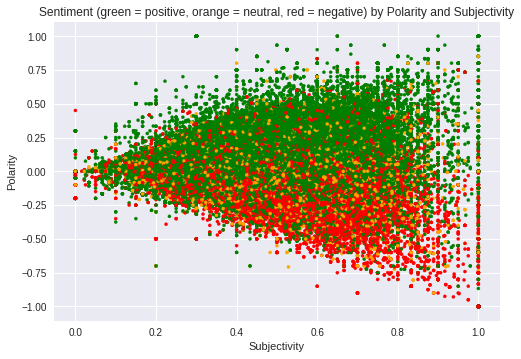

In [ ]:
plot_polarity_subj(pol_subj_train.iloc[:,1], pol_subj_train.iloc[:,0], y_train)

This looks not too bad. The positive class should be good predictable. However, predicting the neutral class accurately will be hard with just these features. The higher the subjectivity is, the more the polarity spreads.

In [ ]:
fit_randomforest(pol_subj_train, y_train, pol_subj_val, y_val)


Random Forest
For Depth: None, F1 score: 0.64, Accuracy: 0.76
For Depth: 10, F1 score: 0.38, Accuracy: 0.68
For Depth: 20, F1 score: 0.45, Accuracy: 0.71
For Depth: 30, F1 score: 0.61, Accuracy: 0.75
For Depth: 50, F1 score: 0.64, Accuracy: 0.76
For Depth: 100, F1 score: 0.64, Accuracy: 0.76
For Depth: 150, F1 score: 0.64, Accuracy: 0.76


The polarity and the subjectivity alone already give quite good scores. We tried to add the onehot encoded drugnames and conditions, but because of the high dimensionality, the scores get worse.

### Rating Prediction

In [ ]:
fit_rf_regression(pol_subj_train, y_train_rating, pol_subj_val, y_val_rating)


Random Forest
For Depth: None, MSE: 7.88
For Depth: 10, MSE: 9.12
For Depth: 20, MSE: 8.41
For Depth: 30, MSE: 7.92
For Depth: 50, MSE: 7.88
For Depth: 100, MSE: 7.88
For Depth: 150, MSE: 7.88


## Doc2Vec

Since we have a training set with over 200'000 reviews, we can try to fit our own embedding. Since we need to embed the reviews as a whole, we use doc2vec instead of word2vec. doc2vec works in a similar fashion, but gives us a representation of the whole review. 

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_clean['review'])]
doc2vec = Doc2Vec(documents, vector_size=10, window=2, min_count=1, workers=4)

In [ ]:
def transform_doc2vec(text, model):
    text = text.split()
    return model.infer_vector(text)

def add_doc2vec_columns(df, textcolumns, model):
    X = df.copy().drop(columns=textcolumns)
    for col in textcolumns:
        embeddings = df[col].apply(transform_doc2vec, model=model)
        expanded = embeddings.apply(pd.Series)
        expanded = expanded.add_prefix(col+'_')
        X = pd.concat([X, expanded], axis=1)
    return X

In [ ]:
X_train_doc2vec = add_doc2vec_columns(X_train_clean, ['review'], doc2vec)
X_val_doc2vec = add_doc2vec_columns(X_val_clean, ['review'], doc2vec)
X_test_doc2vec = add_doc2vec_columns(X_test_clean, ['review'], doc2vec)

In [ ]:
X_train_doc2vec.head()

### Sentiment Analysis

In [ ]:
fit_randomforest(X_train_doc2vec.iloc[:,3:], y_train, X_val_doc2vec.iloc[:,3:], y_val)


Random Forest
For Depth: None, F1 score: 0.31, Accuracy: 0.67


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For Depth: 10, F1 score: 0.27, Accuracy: 0.66
For Depth: 20, F1 score: 0.27, Accuracy: 0.66
For Depth: 30, F1 score: 0.30, Accuracy: 0.67
For Depth: 50, F1 score: 0.31, Accuracy: 0.67
For Depth: 100, F1 score: 0.31, Accuracy: 0.67
For Depth: 150, F1 score: 0.31, Accuracy: 0.67


### Rating Prediction

In [ ]:
fit_rf_regression(X_train_doc2vec.iloc[:,3:], y_train_rating, X_val_doc2vec.iloc[:,3:], y_val_rating)


Random Forest
For Depth: None, MSE: 7.48
For Depth: 10, MSE: 10.59
For Depth: 20, MSE: 10.06
For Depth: 30, MSE: 8.99
For Depth: 50, MSE: 7.66
For Depth: 100, MSE: 7.48
For Depth: 150, MSE: 7.48


## Aggregated Word2Vec

Here we use a pretrained word2vec embedding to get a vector representation of the words in the reviews. Then we aggregate over the whole review to represent it.

In [ ]:
def diag2vec(sentence, w2v_model):
    # aggregates sentences by taking the mean of the word2vec embedding vectors
    if pd.isna(sentence):
        return np.zeros((200,))
    words = [ w for w in sentence.split() if w in w2v_model.vocab ]
    if len(words)==0:
        return np.zeros((200,))
    emb = np.zeros((len(words), 200))
    for i, w in enumerate(words):
        emb[i,:] = w2v_model[w]
    return emb.mean(axis=0)

def pmc_diag2vec(sentence):
    return diag2vec(sentence, pmc_map)

def add_diag2vec_columns(df, textcolumns):
    X = df.copy().drop(columns=textcolumns)
    for col in textcolumns:
        embeddings = df[col].apply(pmc_diag2vec)
        expanded = embeddings.apply(pd.Series)
        expanded = expanded.add_prefix(col+'_')
        X = pd.concat([X, expanded], axis=1)
    return X

In [ ]:
text = ['review']

X_train_sentence2vec = add_diag2vec_columns(X_train_clean, text)
X_val_sentence2vec = add_diag2vec_columns(X_val_clean, text)
X_test_sentence2vec = add_diag2vec_columns(X_test_clean, text)

In [ ]:
X_train_sentence2vec.head()

,drugName,condition,usefulCount,review_0,review_1,review_2,review_3,review_4,review_5,review_6,...,review_190,review_191,review_192,review_193,review_194,review_195,review_196,review_197,review_198,review_199
Id,,,,,,,,,,,,,,,,,,,,,
93740,morphine,pain,26,-0.052312,0.071567,0.148045,-0.065680,-0.055038,0.014063,0.088056,...,0.061930,0.114999,-0.013863,0.086150,-0.066743,0.135664,-0.121165,-0.042438,-0.051890,0.042289
115656,cefprozil,sinusitis,7,-0.194125,0.098484,0.048767,-0.149319,0.042789,0.059333,0.140698,...,0.169069,0.059913,-0.021702,0.100502,-0.193373,0.010452,-0.110091,0.023385,-0.029227,0.016774
215726,copper,birth control,13,-0.145081,0.084976,0.089360,-0.019857,-0.056206,0.080243,0.141676,...,0.062119,0.136460,-0.048215,0.130720,0.014815,0.035561,-0.083481,-0.040095,-0.093934,0.067901
224100,budesonide,inflammatory bowel disease,39,-0.136455,0.074284,0.161759,-0.071802,-0.076431,0.097790,0.167791,...,0.037906,0.140262,-0.050862,0.069170,-0.030703,0.033998,-0.119563,0.010963,-0.036354,0.082871
24726,lactase,lactose intolerance,9,-0.093036,0.061481,0.117494,-0.031707,-0.016935,0.086075,0.133652,...,0.075377,0.197871,-0.025576,0.121117,-0.005958,0.095025,-0.140200,-0.009528,-0.002705,0.066247


### Sentiment Analysis

In [ ]:
fit_randomforest(X_train_sentence2vec.iloc[:,3:], y_train, X_val_sentence2vec.iloc[:,3:], y_val)


Random Forest
For Depth: None, F1 score: 0.74, Accuracy: 0.83
For Depth: 10, F1 score: 0.33, Accuracy: 0.68
For Depth: 20, F1 score: 0.69, Accuracy: 0.81
For Depth: 30, F1 score: 0.74, Accuracy: 0.83
For Depth: 50, F1 score: 0.74, Accuracy: 0.83
For Depth: 100, F1 score: 0.74, Accuracy: 0.83
For Depth: 150, F1 score: 0.74, Accuracy: 0.83


### Rating Prediction

In [ ]:
fit_rf_regression(X_train_sentence2vec.iloc[:,3:], y_train_rating, X_val_sentence2vec.iloc[:,3:], y_val_rating)


Random Forest
For Depth: None, MSE: 5.97
For Depth: 10, MSE: 8.57
For Depth: 20, MSE: 6.24


KeyboardInterrupt: ignored

## RNN

We found that after pre-processing there are about 45k unique words with varying frequency. So, we decided to use pre-trained embedding instead of learning the embedding from our own data.

In this section we try multiple approaches to tackle the problem at hand. As above, we use pre-trained embeddings to train our model. We first find that there are some words in the reviews (ill-formed) for which we do not have pre-trained embedding. So try to implement a spell checker. However, we find that the suggestion made by it are meaningless for most cases. We still created an embedding for it but in vain.

Next, we try to see the impact of each of feature (Drugname, condition and review) on the final rating by the patient. We use pre-trained PMC embedding for drug name and condition and  train a simple feed forward network for both of them separately. We also train by using both of them. However the results are not very impressive.

Then, we train a LSTM on text reviews using another pre-trained embedding by google which gives reasonble values.

In [ ]:
X_train_reviews = X_train_clean['review'].values
X_test_reviews = X_test_clean['review'].values

X = pd.concat([ X_train_clean['review'], X_test_clean['review'] ], axis = 0).values
tk = Tokenizer( lower = True)
tk.fit_on_texts(X)
X_train_seq = tk.texts_to_sequences(X_train_reviews)
X_test_seq = tk.texts_to_sequences(X_test_reviews)
                                  
# Choosing 100 as an intuition based on average sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post')

In [ ]:
# loading pre-trained embedding
# https://code.google.com/archive/p/word2vec/
# http://evexdb.org/pmresources/vec-space-models/
google_map = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
pmc_map = KeyedVectors.load_word2vec_format('PMC-w2v.bin', binary=True)


### Experimenting

In [ ]:
# max_seq_len = max([len(s) for s in X_train_seq])
# avg_seq_len = np.average([len(s) for s in X_train_seq])
# ​
# print(f'Max review length {max_seq_len} and average sequence length = {avg_seq_len}')

In [ ]:

# no_map = []
# for word in tk.word_counts.keys():
#   try:
#     google_map[word] 
 
#   except:
#     no_map.append(word)

# print("We have pretrained word2vec of {} words out of total vocab of {}".format(len(tk.word_counts.keys())- len(no_map), len(tk.word_counts.keys())))


We have pretrained word2vec of 29896 words out of total vocab of 45842


In [ ]:
# Having a look at words without embedding
# no_map

In [ ]:
# !apt-get update
# !apt-get install python-dev 
# !apt-get install libhunspell-dev
# !pip install hunspell
# import hunspell
# !npm install dictionary-en-us

In [ ]:
# spellchecker = hunspell.HunSpell('node_modules/dictionary-en-us/index.dic',
#                                  'node_modules/dictionary-en-us/index.aff')

In [ ]:
# bad_words = []
# corrected = []
# for word in no_map:
#   try:
#     corrected.append([word, spellchecker.suggest(word)[0]])
#   except:
#     bad_words.append(word)

In [ ]:
# print(corrected)

[['bystolic', 'systolic'], ['intuniv', 'int univ'], ['gestodene', 'lodestone'], ['lybrel', 'rely'], ['preassure', 'pressure'], ['rockhard', 'rock hard'], ['cummed', 'scummed'], ['abilify', 'ability'], ['clondine', 'cloudiness'], ['keppera', 'keeper'], ['chateal', 'chateau'], ['deplin', 'depletion'], ['asacol', 'Pensacola'], ['pentasa', 'peasant'], ['delsym', 'Delmer'], ['nexplanon', 'explanation'], ['saxenda', 'Sendai'], ['litres', 'liters'], ['fitbit', 'fit bit'], ['tegretol', 'Gretel'], ['tasigna', 'Anastasia'], ['combivir', 'combiner'], ['kaletra', 'rattletrap'], ['pluz', 'plus'], ['trazadone', 'methadone'], ['nasel', 'easel'], ['nexplanont', 'explanation'], ['embrel', 'tumbrel'], ['centre', 'center'], ['vaniqa', 'vanilla'], ['daytrana', 'Dayton'], ['cipralex', 'reciprocal'], ['excedrin', 'Excedrin'], ['imitrex', 'extremity'], ['viberzi', 'vizier'], ['tumour', 'tumor'], ['contrave', 'contrive'], ['eot', 'toe'], ['betmiga', 'mitigate'], ['trulicity', 'rusticity'], ['sulphur', 'sulfur

The above output shows that even though spell checker gives suggestions for most of the words but the suggestions does not really help to predict the correct word

### Feedforward network using only drug Names

In [ ]:
#PMC embedding for drug names and conditions which would be added to the last layer of LSTM

Drug_embedding = np.zeros((len(X_train_clean), 200))

for idx, drug in enumerate(X_train_clean['drugName']):
  
  embedding_vec = np.zeros(200)
  
  if (len(drug) == 1):
    try:
      embedding_vec = pmc_map[drug]
    except:
      continue
  
  elif len(drug) > 1:

    for d in drug:
      try:
        embedding_vec += pmc_map[d]
      except:
        continue
    embedding_vec = embedding_vec/len(drug)
  Drug_embedding[idx] = embedding_vec

In [ ]:
Drug_embedding = StandardScaler().fit_transform(Drug_embedding)

In [ ]:
from keras.models import Model
Inp = Input(shape = (200,))
# l0 = Masking(mask_value = 0)(Inp)
#l1 = Dense(300, activation = 'relu')(Inp)
#l2 = Dropout(0.3)(l1)
l3 = Dense(100, activation = 'relu')(Inp)
#l4 = Dropout(0.25)(l3)
l5 = Dense(50, activation = 'relu')(l3)
#l6 = Dropout(0.2)(l5)
label = Dense(3, activation = 'softmax')(l5)
adam = optimizers.Adam(lr = 0.001)

model = Model(inputs = Inp, outputs = label)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_90 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_91 (Dense)             (None, 3)                 153       
Total params: 25,303
Trainable params: 25,303
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train_ohe = pd.get_dummies(y_train).values

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(Drug_embedding, y_train_ohe, test_size=0.3, random_state=42, shuffle = True)

model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), batch_size=128, epochs = 10, shuffle=True)

[11745  6472 16783]
[5013 2761 7226]
Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 5s 133us/step - loss: 1.0253 - acc: 0.4947 - val_loss: 1.0050 - val_acc: 0.5125
Epoch 2/10
35000/35000 [==============================] - 2s 46us/step - loss: 0.9994 - acc: 0.5153 - val_loss: 0.9979 - val_acc: 0.5157
Epoch 3/10
35000/35000 [==============================] - 2s 47us/step - loss: 0.9927 - acc: 0.5210 - val_loss: 0.9974 - val_acc: 0.5168
Epoch 4/10
35000/35000 [==============================] - 2s 46us/step - loss: 0.9886 - acc: 0.5240 - val_loss: 1.0024 - val_acc: 0.5119
Epoch 5/10
35000/35000 [==============================] - 2s 47us/step - loss: 0.9856 - acc: 0.5240 - val_loss: 0.9933 - val_acc: 0.5246
Epoch 6/10
35000/35000 [==============================] - 2s 47us/step - loss: 0.9818 - acc: 0.5274 - val_loss: 0.9918 - val_acc: 0.5248
Epoch 7/10
35000/35000 [==============================] - 2s 46us/step - loss: 0.9810 - ac

In [ ]:
np.argmax(model.predict(X_val_nn[:100]), axis = 1)

array([2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

### Feedforward network using only Conditions

In [ ]:
#PMC embedding for conditions which would be added to the last layer of LSTM
Cond_embedding = np.zeros((len(X_train_clean), 400))

for idx, cond in enumerate(X_train_clean['condition']):
  
  cond = cond.split()
  embedding_vec = np.zeros(400)
  
  if (len(cond) == 1):
    try:
      embedding_vec[:200] = pmc_map[drug]
    except:
      continue
  
  elif len(cond) == 2:
      try:
        embedding_vec[:200] = pmc_map[cond[0]]
        embedding_vec[200:] = pmc_map[cond[1]]
      except:
        continue

  Cond_embedding[idx] = embedding_vec

In [ ]:
from keras.models import Model
Inp = Input(shape = (400,))
# l0 = Masking(mask_value = 0)(Inp)
l1 = Dense(300, activation = 'relu')(Inp)
l2 = Dropout(0.3)(l1)
l3 = Dense(200, activation = 'relu')(l2)
l4 = Dropout(0.25)(l3)
l5 = Dense(50, activation = 'relu')(l4)
l6 = Dropout(0.2)(l5)
label = Dense(3, activation = 'softmax')(l6)
adam = optimizers.Adam(lr = 0.001)

model = Model(inputs = Inp, outputs = label)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 300)               120300    
_________________________________________________________________
dropout_32 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_33 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 50)                10050     
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)                0         
__________

In [ ]:
y_train_ohe = pd.get_dummies(y_train)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(Cond_embedding[:50000], y_train_ohe[:50000], test_size=0.3, random_state=42)
model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), batch_size=128, epochs = 20)

Train on 35000 samples, validate on 15000 samples
Epoch 1/20
35000/35000 [==============================] - 4s 124us/step - loss: 0.8609 - acc: 0.6582 - val_loss: 0.8446 - val_acc: 0.6599
Epoch 2/20
35000/35000 [==============================] - 2s 58us/step - loss: 0.8491 - acc: 0.6616 - val_loss: 0.8437 - val_acc: 0.6599
Epoch 3/20
35000/35000 [==============================] - 2s 58us/step - loss: 0.8457 - acc: 0.6616 - val_loss: 0.8452 - val_acc: 0.6597
Epoch 4/20
35000/35000 [==============================] - 2s 57us/step - loss: 0.8436 - acc: 0.6616 - val_loss: 0.8451 - val_acc: 0.6591
Epoch 5/20
35000/35000 [==============================] - 2s 56us/step - loss: 0.8423 - acc: 0.6620 - val_loss: 0.8430 - val_acc: 0.6596
Epoch 6/20
35000/35000 [==============================] - 2s 57us/step - loss: 0.8421 - acc: 0.6619 - val_loss: 0.8436 - val_acc: 0.6599
Epoch 7/20
35000/35000 [==============================] - 2s 59us/step - loss: 0.8418 - acc: 0.6614 - val_loss: 0.8437 - val_ac

In [ ]:
model.predict(X_val_nn)

array([[0.18565875, 0.1048053 , 0.70953596],
       [0.2590296 , 0.12609337, 0.61487705],
       [0.28092235, 0.18604603, 0.53303164],
       ...,
       [0.2590296 , 0.12609337, 0.61487705],
       [0.18565875, 0.1048053 , 0.70953596],
       [0.28092235, 0.18604603, 0.53303164]], dtype=float32)

### Combining DrugName and Condition

In [ ]:
Drug_Cond = np.concatenate((Drug_embedding, Cond_embedding), axis = 1)
np.shape(Drug_Cond)

(161297, 600)

In [ ]:
from keras.models import Model
Inp = Input(shape = (600,))
l0 = Masking(mask_value = 0)(Inp)
l1 = Dense(300, activation = 'relu')(l0)
l2 = Dropout(0.3)(l1)
l3 = Dense(200, activation = 'relu')(l2)
l4 = Dropout(0.25)(l3)
l5 = Dense(50, activation = 'relu')(l4)
l6 = Dropout(0.2)(l5)
label = Dense(3, activation = 'softmax')(l6)
adam = optimizers.Adam(lr = 0.001)

model = Model(inputs = Inp, outputs = label)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 600)               0         
_________________________________________________________________
masking_8 (Masking)          (None, 600)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_26 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 50)                10050     
__________

In [ ]:
y_train_ohe = pd.get_dummies(y_train)
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(Drug_Cond, y_train_ohe, test_size=0.3, random_state=42)
model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), batch_size=256, epochs = 50)

Train on 112907 samples, validate on 48390 samples
Epoch 1/50
112907/112907 [==============================] - 3s 31us/step - loss: 0.8294 - acc: 0.6671 - val_loss: 0.8235 - val_acc: 0.6695
Epoch 2/50
112907/112907 [==============================] - 4s 31us/step - loss: 0.8275 - acc: 0.6675 - val_loss: 0.8226 - val_acc: 0.6691
Epoch 3/50
112907/112907 [==============================] - 4s 31us/step - loss: 0.8266 - acc: 0.6675 - val_loss: 0.8228 - val_acc: 0.6700
Epoch 4/50
112907/112907 [==============================] - 4s 31us/step - loss: 0.8260 - acc: 0.6680 - val_loss: 0.8217 - val_acc: 0.6696
Epoch 5/50
112907/112907 [==============================] - 4s 31us/step - loss: 0.8254 - acc: 0.6679 - val_loss: 0.8218 - val_acc: 0.6696
Epoch 6/50
112907/112907 [==============================] - 4s 31us/step - loss: 0.8252 - acc: 0.6682 - val_loss: 0.8208 - val_acc: 0.6698
Epoch 7/50
112907/112907 [==============================] - 4s 32us/step - loss: 0.8246 - acc: 0.6682 - val_loss: 0

### Training only on review data

Since, the spell checker does not seem to provide reasonable advantage, we would ignore all the words not found in the pre-trained vector.

In [ ]:
# Without using the drugName and condition, can add them later once we have reasonable results with this model
# Takes some time to run
vocab = tk.word_counts.keys()
vocab_size = len(vocab) + 1
non_zero = 0
embedding_matrix = np.zeros((vocab_size, 300))

for idx, word in enumerate(vocab):
  
  try:
    embedding_vec = google_map[word]
    non_zero += 1
  except:
    embedding_vec = None
  
  if embedding_vec is not None:
    embedding_matrix[idx+1] = embedding_vec #Wasted hours to debug this "+1"

In [ ]:
max_words = 100
embedding_size = 300

In [ ]:

Inp = Input(shape = (100,))
Embd = Embedding(vocab_size, embedding_size, input_length=max_words, weights = [embedding_matrix], trainable = False)(Inp)
# mask = Masking(mask_value=0)(Embd)
lstm = LSTM(100)(Embd)
# drop = Dropout(0.1)(lstm)
output = Dense(3, activation='softmax')(lstm)
adam = optimizers.Adam(lr = 0.001)

model = Model(inputs = Inp, outputs = output)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
chk_pt = ModelCheckpoint("best.model.hdf5", save_best_only = True, monitor = 'val_loss')
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 100, 300)          14764500  
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 303       
Total params: 14,925,203
Trainable params: 160,703
Non-trainable params: 14,764,500
_________________________________________________________________


In [ ]:
# One hot encoding output labels
y_train_ohe = pd.get_dummies(y_train)

0.0
126234.0
233100.0


In [ ]:
X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_pad, y_train_ohe, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train_rnn, y_train_rnn, validation_data=(X_val_rnn, y_val_rnn), batch_size=256, epochs = 50, callbacks = [reduce_lr, chk_pt])

Train on 129037 samples, validate on 32260 samples
Epoch 1/50
129037/129037 [==============================] - 124s 961us/step - loss: 0.8239 - acc: 0.6710 - val_loss: 0.7877 - val_acc: 0.6915
Epoch 2/50
129037/129037 [==============================] - 119s 924us/step - loss: 0.7233 - acc: 0.7151 - val_loss: 0.6783 - val_acc: 0.7355
Epoch 3/50
129037/129037 [==============================] - 120s 927us/step - loss: 0.6681 - acc: 0.7416 - val_loss: 0.6474 - val_acc: 0.7479
Epoch 4/50
129037/129037 [==============================] - 119s 919us/step - loss: 0.6305 - acc: 0.7572 - val_loss: 0.6614 - val_acc: 0.7333
Epoch 5/50
129037/129037 [==============================] - 119s 925us/step - loss: 0.6075 - acc: 0.7667 - val_loss: 0.6576 - val_acc: 0.7435
Epoch 6/50
129037/129037 [==============================] - 120s 927us/step - loss: 0.5833 - acc: 0.7754 - val_loss: 0.6128 - val_acc: 0.7561
Epoch 7/50
129037/129037 [==============================] - 117s 910us/step - loss: 0.5649 - acc:

Results on validation data

In [ ]:
y_true = np.argmax(y_val_rnn.values, axis = 1)
y_pred_rnn = np.argmax(model.predict(X_val_rnn), axis = 1)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score

conf_mat = confusion_matrix(y_true, y_pred_rnn)
f1 = f1_score(y_true, y_pred_rnn, average = 'macro')
print(f1)
print(conf_mat)

0.7162639447996378
[[ 5250   751   990]
 [  870  1904  1150]
 [ 1001  1011 19333]]


Results on Test data

In [ ]:
y_test_enc = y_test
y_test_pred = np.argmax(model.predict(X_test_pad), axis = 1)

In [ ]:
from collections import Counter
Counter(y_test_enc)

Counter({0.0: 11838, 1.0: 6488, 2.0: 35440})

In [ ]:
# Since the class 2 in prominent, we use micro=average
f1 = f1_score(y_test_enc, y_test_pred, average = 'micro')
print(f"f1: {f1}")

f1: 0.8117397611873675


In [ ]:

score = model.evaluate(X_test_pad, pd.get_dummies(y_test_enc))

print(f"loss {score[0]}, accuracy: {score[1]}")

loss 0.6698253525512691, accuracy: 0.8117397611851503


### Rating prediction

The function below gives the following encoding of the rating:
0: [0, 0, 0, 0, 0, 0, 0, 0, 0 ]
1: [1, 0, 0, 0, 0, 0, 0, 0, 0 ]
2: [1, 1, 0, 0, 0, 0, 0, 0, 0 ]

in the hope to make the model learn the ordinal structure

In [ ]:
def get_ordinal_labels():
  y_train = train.loc[:, "rating"].values
  y_test = test.loc[:, "rating"].values
  
  uniq_lab = len(np.unique(y_train))
  y_train_ord = np.zeros( (len(y_train), uniq_lab - 1) )
  y_test_ord = np.zeros( (len(y_test), uniq_lab - 1) )
  
  for idx, y in enumerate(y_train):
    if y > 1:
      y_train_ord[idx, :int(y)-1] = np.ones(int(y)-1)

  for idx, y in enumerate(y_test):
    if y > 1:
      y_test_ord[idx, :int(y)-1] = np.ones(int(y)-1)
      
  return y_train_ord, y_test_ord

In [ ]:
y_train_ord, y_test_ord = get_ordinal_labels()
# These don't really help learn the sentiment with binary_crossentropy loss

Casting it as regression problem after scaling the rating and using sigmoid along with MSE does not yield good results
One-hot encoding does not take into account the ordinal structure of the labels

In [ ]:
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
Inp = Input(shape = (100,))
Embd = Embedding(vocab_size, embedding_size, input_length=max_words, weights = [embedding_matrix], trainable = False)(Inp)
# mask = Masking(mask_value=0)(Embd)
lstm = LSTM(100)(Embd)
# drop = Dropout(0.1)(lstm)
output = Dense(1, activation='sigmoid')(lstm)
adam = optimizers.Adam(lr = 0.01)

model = Model(inputs = Inp, outputs = output)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
chk_pt = ModelCheckpoint("rating.best.model.hdf5", save_best_only = True, monitor = 'val_loss')
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 100, 300)          13752900  
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 13,913,401
Trainable params: 160,501
Non-trainable params: 13,752,900
_________________________________________________________________


In [ ]:
X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_pad, y_train/10.0, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train_rnn, y_train_rnn, validation_data=(X_val_rnn, y_val_rnn), batch_size=256, epochs = 10, callbacks = [reduce_lr, chk_pt])

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 18s 1ms/step - loss: 0.1183 - acc: 0.3180 - val_loss: 0.1082 - val_acc: 0.3065
Epoch 2/10
16000/16000 [==============================] - 14s 904us/step - loss: 0.1073 - acc: 0.3226 - val_loss: 0.1079 - val_acc: 0.3065
Epoch 3/10
16000/16000 [==============================] - 15s 910us/step - loss: 0.1072 - acc: 0.3226 - val_loss: 0.1081 - val_acc: 0.3065
Epoch 4/10
16000/16000 [==============================] - 14s 905us/step - loss: 0.1089 - acc: 0.3212 - val_loss: 0.1091 - val_acc: 0.3058
Epoch 5/10
16000/16000 [==============================] - 15s 915us/step - loss: 0.1091 - acc: 0.3209 - val_loss: 0.1087 - val_acc: 0.3055
Epoch 6/10
16000/16000 [==============================] - 15s 908us/step - loss: 0.1122 - acc: 0.3222 - val_loss: 0.1154 - val_acc: 0.3065
Epoch 7/10
16000/16000 [==============================] - 15s 909us/step - loss: 0.1076 - acc: 0.3226 - val_loss: 0.104

In [ ]:
y_pred = model.predict(X_test_pad)

One could also extract the last layer of the LSTM for sentiments and use it along with embeddings of drugs, conditions and useful counts in hope for better results for both sentiment and ratings

## BERT

### BERT Sentimental Analysis

Bidirectional Encoder Representations from Transformers, or BERT is a new technique for NLP pretraining developed by Google and it has been open sourced. Now we fine tune it to work with our sentimental analysis task. Since the processors they provided don't include sentimental classification task, we need to wrtie our own processor and modify related codes. 

In [ ]:
import tf_metrics
if not 'bert_repo' in sys.path:
	sys.path += ['bert_repo']

import modeling
import optimization
import run_classifier
import tokenization

BERT_PRETRAINED_DIR = 'uncased_L-12_H-768_A-12'

In [ ]:
# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 20.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 128

# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
ITERATIONS_PER_LOOP = 1000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, "vocab.txt")
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, "bert_config.json")
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, "bert_model.ckpt")
DO_LOWER_CASE = True

OUTPUT_DIR = "output"
if os.path.exists(OUTPUT_DIR)==False:
    os.mkdir(OUTPUT_DIR)
DATA_DIR = ""

Below are the classes and functions that require modifications.

In [ ]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text, label=None):
        """Constructs a InputExample.
        Args:
          guid: Unique id for the example.
          text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
          label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text = text
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id,):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_data(cls, input_file):
        data = pd.read_csv(input_file, sep='\t', header=0, engine='python', error_bad_lines=False)
        X = data['review'].values.tolist()
        y = data['rating']
        
        y_res = np.zeros(y.shape[0])
        y_res[y >= 4] = 1
        y_res[y >= 7] = 2
        
        lines = []
        for line, label in zip(X, y_res):
            line_ = html.unescape(line)
            label_ = str(int(label))
            lines.append([line_, label_])
        
        return lines


class SentimentProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
        return self._create_example(
            self._read_data(os.path.join(data_dir, "drugsComTrain_raw.tsv")), "train"
        )

    def get_dev_examples(self, data_dir):
        return self._create_example(
            self._read_data(os.path.join(data_dir, "drugsComTest_raw.tsv")), "dev"
        )

    def get_labels(self):
        return ['0', '1', '2']

    def _create_example(self, lines, set_type):
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text = tokenization.convert_to_unicode(line[0])
            label = tokenization.convert_to_unicode(line[1])
            examples.append(InputExample(guid=guid, text=text, label=label))
        return examples

def convert_single_example(ex_index, example, label_list, max_seq_length, tokenizer,mode):
    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i
    
    tokens_text = tokenizer.tokenize(example.text)
    
    if len(tokens_text) >= max_seq_length - 1:
        tokens_text = tokens_text[0:(max_seq_length - 2)]
        
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    for i, token in enumerate(tokens_text):
        tokens.append(token)
    tokens.append("[SEP]")
    
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        tokens.append("**NULL**")
    segment_ids = [1] * max_seq_length
    label_id = label_map[example.label]

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

#     if ex_index < 5:
#         tf.logging.info("*** Example ***")
#         tf.logging.info("guid: %s" % (example.guid))
#         tf.logging.info("tokens: %s" % " ".join(
#             [tokenization.printable_text(x) for x in tokens]))
#         tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
#         tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
#         tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
#         tf.logging.info("label_ids: %s" % " ".join([str(x) for x in label_ids]))

    feature = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
    )
    return feature


def file_based_convert_examples_to_features(
        examples, label_list, max_seq_length, tokenizer, output_file,mode=None
):
    writer = tf.python_io.TFRecordWriter(output_file)
    for (ex_index, example) in enumerate(examples):
#         if ex_index % 5000 == 0:
#             tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))
        feature = convert_single_example(ex_index, example, label_list, max_seq_length, tokenizer,mode)

        def create_int_feature(values):
            f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
            return f

        features = collections.OrderedDict()
        features["input_ids"] = create_int_feature(feature.input_ids)
        features["input_mask"] = create_int_feature(feature.input_mask)
        features["segment_ids"] = create_int_feature(feature.segment_ids)
        features["label_ids"] = create_int_feature([feature.label_id])
        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())


def file_based_input_fn_builder(input_file, seq_length, is_training, drop_remainder):
    name_to_features = {
        "input_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
        "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "label_ids": tf.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        example = tf.parse_single_example(record, name_to_features)
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.to_int32(t)
            example[name] = t
        return example

    def input_fn(params):
        batch_size = params["batch_size"]
        d = tf.data.TFRecordDataset(input_file)
        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)
        d = d.apply(tf.contrib.data.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=batch_size,
            drop_remainder=drop_remainder
        ))
        return d
    return input_fn

def create_model(bert_config, is_training, input_ids, input_mask,
                 segment_ids, labels, num_labels, use_one_hot_embeddings):
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings
    )

    output_layer = model.get_pooled_output()

    hidden_size = output_layer.shape[-1].value

    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
      if is_training:
        # I.e., 0.1 dropout
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

      logits = tf.matmul(output_layer, output_weights, transpose_b=True)
      logits = tf.nn.bias_add(logits, output_bias)
      probabilities = tf.nn.softmax(logits, axis=-1)
      log_probs = tf.nn.log_softmax(logits, axis=-1)
      predict = tf.argmax(probabilities,axis=-1)

      one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

      per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
      loss = tf.reduce_mean(per_example_loss)
      
    return (loss, per_example_loss, logits, probabilities, predict)
        
def model_fn_builder(bert_config, num_labels, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu,
                     use_one_hot_embeddings):
    def model_fn(features, labels, mode, params):
#         tf.logging.info("*** Features ***")
#         for name in sorted(features.keys()):
#             tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]
        is_training = (mode == tf.estimator.ModeKeys.TRAIN)

        (total_loss, per_example_loss, logits, probabilities, predictions) = create_model(
            bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
            num_labels, use_one_hot_embeddings)
        tvars = tf.trainable_variables()
        scaffold_fn = None
        if init_checkpoint:
            (assignment_map, initialized_variable_names) = modeling.get_assignment_map_from_checkpoint(tvars,init_checkpoint)
            tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
            tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
#         tf.logging.info("**** Trainable Variables ****")

#         for var in tvars:
#             init_string = ""
#             if var.name in initialized_variable_names:
#                 init_string = ", *INIT_FROM_CKPT*"
#             tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
#                             init_string)
        output_spec = None
        if mode == tf.estimator.ModeKeys.TRAIN:
            train_op = optimization.create_optimizer(
                total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode,
                loss=total_loss,
                train_op=train_op,
                scaffold_fn=scaffold_fn)
        elif mode == tf.estimator.ModeKeys.EVAL:
            
            def metric_fn(label_ids, logits):
                predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
                precision = tf_metrics.precision(label_ids,predictions,num_labels,average="macro")
                recall = tf_metrics.recall(label_ids,predictions,num_labels,average="macro")
                f = tf_metrics.f1(label_ids,predictions,num_labels,average="macro")
                accuracy = tf.metrics.accuracy(labels=label_ids, predictions=predictions)

                return {
                    "eval_precision":precision,
                    "eval_recall":recall,
                    "eval_f": f,
                    "eval_accuracy": accuracy
                }
            eval_metrics = (metric_fn, [label_ids, logits])
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode,
                loss=total_loss,
                eval_metrics=eval_metrics,
                scaffold_fn=scaffold_fn)
        else:
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
            mode=mode,
            predictions={"probabilities": probabilities},
            scaffold_fn=scaffold_fn)
        return output_spec
    return model_fn

Training

In [ ]:
processor = SentimentProcessor()
label_list = processor.get_labels()
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)

is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2

run_config = tf.contrib.tpu.RunConfig(
        cluster=None,
        master=None,
        model_dir=OUTPUT_DIR,
        save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
        tpu_config=tf.contrib.tpu.TPUConfig(
            iterations_per_loop=ITERATIONS_PER_LOOP,
            num_shards=NUM_TPU_CORES,
            per_host_input_for_training=is_per_host))

train_examples = processor.get_train_examples(DATA_DIR)
num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)


model_fn = model_fn_builder(
        bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
        num_labels=len(label_list),
        init_checkpoint=INIT_CHECKPOINT,
        learning_rate=LEARNING_RATE,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        use_tpu=False,
        use_one_hot_embeddings=False)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=PREDICT_BATCH_SIZE)

train_file = os.path.join(OUTPUT_DIR, "train.tf_record")
file_based_convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer, train_file)
# tf.logging.info("***** Running training *****")
# tf.logging.info("  Num examples = %d", len(train_examples))
# tf.logging.info("  Batch size = %d", TRAIN_BATCH_SIZE)
# tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = file_based_input_fn_builder(
    input_file=train_file,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

Due to the long training time, we did not do any hyperparameter tuning or model selection for BERT. Therefore, the results are directly evaluated on test set.



In [ ]:
eval_examples = processor.get_dev_examples(DATA_DIR)
eval_file = os.path.join(OUTPUT_DIR, "eval.tf_record")
file_based_convert_examples_to_features(
    eval_examples, label_list, MAX_SEQ_LENGTH, tokenizer, eval_file)

# tf.logging.info("***** Running evaluation *****")
# tf.logging.info("  Num examples = %d", len(eval_examples))
# tf.logging.info("  Batch size = %d", TRAIN_BATCH_SIZE)
eval_steps = None
eval_drop_remainder = False
eval_input_fn = file_based_input_fn_builder(
    input_file=eval_file,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=eval_drop_remainder)
result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    tf.logging.info("***** Eval results *****")
    for key in sorted(result.keys()):
        tf.logging.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

Since it takes very long time to train the model, we attached eval_results for your reference (f1 score:  0.87409425, accuracy: 0.9251758). The latest checkpoint is also attached if you want to check our results. If you want to train it from scrath, you can simply remove the checkpoints.

### BERT Ratings Prediction

The BERT model originally does not support regression, but we modified it to adapt to this task. 
The first two cells (files importing and variables intialization) can be left unchanged, but for clarification and completeness, they are copied here too.

In [ ]:
import tf_metrics
if not 'bert_repo' in sys.path:
	sys.path += ['bert_repo']

import modeling
import optimization
import run_classifier
import tokenization

BERT_PRETRAINED_DIR = 'uncased_L-12_H-768_A-12'

In [ ]:
# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
PREDICT_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 20.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 128

# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
ITERATIONS_PER_LOOP = 1000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, "vocab.txt")
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, "bert_config.json")
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, "bert_model.ckpt")
DO_LOWER_CASE = True

OUTPUT_DIR = "output_regression"
if os.path.exists(OUTPUT_DIR)==False:
    os.mkdir(OUTPUT_DIR)
DATA_DIR = ""

In [ ]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text, label=None):
        """Constructs a InputExample.
        Args:
          guid: Unique id for the example.
          text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
          label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text = text
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id,):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_data(cls, input_file):
        data = pd.read_csv(input_file, sep='\t', header=0, engine='python', error_bad_lines=False)
        X = data['review'].values.tolist()
        y = data['rating'].values.tolist()
        
        lines = []
        for line, label in zip(X, y):
            line_ = html.unescape(line)
            label_ = str(label)
            lines.append([line_, label_])
        
        return lines


class RatingProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
        return self._create_example(
            self._read_data(os.path.join(data_dir, "drugsComTrain_raw.tsv")), "train"
        )

    def get_dev_examples(self, data_dir):
        return self._create_example(
            self._read_data(os.path.join(data_dir, "drugsComTest_raw.tsv")), "dev"
        )

    def _create_example(self, lines, set_type):
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text = tokenization.convert_to_unicode(line[0])
            label = tokenization.convert_to_unicode(line[1])
            examples.append(InputExample(guid=guid, text=text, label=label))
        return examples

def convert_single_example(ex_index, example, max_seq_length, tokenizer,mode):
    tokens_text = tokenizer.tokenize(example.text)
    
    if len(tokens_text) >= max_seq_length - 1:
        tokens_text = tokens_text[0:(max_seq_length - 2)]
        
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    for i, token in enumerate(tokens_text):
        tokens.append(token)
    tokens.append("[SEP]")
    
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        tokens.append("**NULL**")
    segment_ids = [1] * max_seq_length
    label_id = float(example.label)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

#     if ex_index < 5:
#         tf.logging.info("*** Example ***")
#         tf.logging.info("guid: %s" % (example.guid))
#         tf.logging.info("tokens: %s" % " ".join(
#             [tokenization.printable_text(x) for x in tokens]))
#         tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
#         tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
#         tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
#         tf.logging.info("label_ids: %s" % " ".join([str(x) for x in label_ids]))

    feature = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
    )
    return feature


def file_based_convert_examples_to_features(
        examples, max_seq_length, tokenizer, output_file,mode=None
):
    writer = tf.python_io.TFRecordWriter(output_file)
    for (ex_index, example) in enumerate(examples):
#         if ex_index % 5000 == 0:
#             tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))
        feature = convert_single_example(ex_index, example, max_seq_length, tokenizer,mode)

        def create_int_feature(values):
            f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
            return f
        
        def create_float_feature(values):
            f = tf.train.Feature(float_list=tf.train.FloatList(value=list(values)))
            return f

        features = collections.OrderedDict()
        features["input_ids"] = create_int_feature(feature.input_ids)
        features["input_mask"] = create_int_feature(feature.input_mask)
        features["segment_ids"] = create_int_feature(feature.segment_ids)
        features["label_ids"] = create_float_feature([feature.label_id])
        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())


def file_based_input_fn_builder(input_file, seq_length, is_training, drop_remainder):
    name_to_features = {
        "input_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
        "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "label_ids": tf.FixedLenFeature([], tf.float32),
    }

    def _decode_record(record, name_to_features):
        example = tf.parse_single_example(record, name_to_features)
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.to_int32(t)
            example[name] = t
        return example

    def input_fn(params):
        batch_size = params["batch_size"]
        d = tf.data.TFRecordDataset(input_file)
        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)
        d = d.apply(tf.contrib.data.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=batch_size,
            drop_remainder=drop_remainder
        ))
        return d
    return input_fn

def create_model(bert_config, is_training, input_ids, input_mask,
                 segment_ids, labels, num_labels, use_one_hot_embeddings):
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings
    )

    output_layer = model.get_pooled_output()

    hidden_size = output_layer.shape[-1].value

    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        if is_training:
        # I.e., 0.1 dropout
            output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)

    predicts = tf.nn.relu(logits)

    predicts = tf.squeeze(predicts, [1])
    loss = tf.losses.mean_squared_error(labels, predicts)
      
    return (loss, predicts)
        
def model_fn_builder(bert_config, num_labels, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu,
                     use_one_hot_embeddings):
    def model_fn(features, labels, mode, params):
#         tf.logging.info("*** Features ***")
#         for name in sorted(features.keys()):
#             tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]
        is_training = (mode == tf.estimator.ModeKeys.TRAIN)

        (total_loss, predicts) = create_model(
            bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
            num_labels, use_one_hot_embeddings)
        tvars = tf.trainable_variables()
        scaffold_fn = None
        if init_checkpoint:
            (assignment_map, initialized_variable_names) = modeling.get_assignment_map_from_checkpoint(tvars,init_checkpoint)
            tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
            tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
#         tf.logging.info("**** Trainable Variables ****")

#         for var in tvars:
#             init_string = ""
#             if var.name in initialized_variable_names:
#                 init_string = ", *INIT_FROM_CKPT*"
#             tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
#                             init_string)
        output_spec = None
        if mode == tf.estimator.ModeKeys.TRAIN:
            train_op = optimization.create_optimizer(
                total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode,
                loss=total_loss,
                train_op=train_op,
                scaffold_fn=scaffold_fn)
        elif mode == tf.estimator.ModeKeys.EVAL:
            
            def metric_fn(label_ids, predicts):
                mse = tf.metrics.mean_squared_error(label_ids, predicts)
                predicts_ = tf.contrib.metrics.streaming_concat(predicts)
                labels_ = tf.contrib.metrics.streaming_concat(label_ids)

                return {
                    "eval_mse":mse,
                    "predicts": predicts_,
                    "labels": labels_
                }
            eval_metrics = (metric_fn, [label_ids, predicts])
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode,
                loss=total_loss,
                eval_metrics=eval_metrics,
                scaffold_fn=scaffold_fn)
        else:
            output_spec = tf.contrib.tpu.TPUEstimatorSpec(
            mode=mode,
            predictions=predicts,
            scaffold_fn=scaffold_fn)
        return output_spec
    return model_fn

In [ ]:
processor = RatingProcessor()
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)

is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2

run_config = tf.contrib.tpu.RunConfig(
        cluster=None,
        master=None,
        model_dir=OUTPUT_DIR,
        save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
        tpu_config=tf.contrib.tpu.TPUConfig(
            iterations_per_loop=ITERATIONS_PER_LOOP,
            num_shards=NUM_TPU_CORES,
            per_host_input_for_training=is_per_host))

train_examples = processor.get_train_examples(DATA_DIR)
num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)


model_fn = model_fn_builder(
        bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
        num_labels=1,
        init_checkpoint=INIT_CHECKPOINT,
        learning_rate=LEARNING_RATE,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        use_tpu=False,
        use_one_hot_embeddings=False)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=PREDICT_BATCH_SIZE)

train_file = os.path.join(OUTPUT_DIR, "train.tf_record")
file_based_convert_examples_to_features(
    train_examples, MAX_SEQ_LENGTH, tokenizer, train_file)
# tf.logging.info("***** Running training *****")
# tf.logging.info("  Num examples = %d", len(train_examples))
# tf.logging.info("  Batch size = %d", TRAIN_BATCH_SIZE)
# tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = file_based_input_fn_builder(
    input_file=train_file,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

In [ ]:
eval_examples = processor.get_dev_examples(DATA_DIR)
eval_file = os.path.join(OUTPUT_DIR, "eval.tf_record")
file_based_convert_examples_to_features(
    eval_examples, MAX_SEQ_LENGTH, tokenizer, eval_file)

# tf.logging.info("***** Running evaluation *****")
# tf.logging.info("  Num examples = %d", len(eval_examples))
# tf.logging.info("  Batch size = %d", TRAIN_BATCH_SIZE)
eval_steps = None
eval_drop_remainder = False
eval_input_fn = file_based_input_fn_builder(
    input_file=eval_file,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=eval_drop_remainder)
result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)
output_eval_file = os.path.join(OUTPUT_DIR, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    tf.logging.info("***** Eval results *****")
    for key in sorted(result.keys()):
        tf.logging.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

Similarly, the latest checkpoint and results file are attached.

## Scores on test set for sentiment analysis

Note that in order to compare the natural language processing approaches, we only use the review column for training and prediction.

In [ ]:
scores = {}

In [ ]:
# TFIDF on cleaned reviews
clf = Pipeline([('vec', TfidfVectorizer()),('clf', RandomForestClassifier(n_estimators=100))])
clf.fit(X_train_clean_unsplit['review'], y_train_unsplit)
y_pred = clf.predict(X_test_clean['review'])
f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
scores['TFIDF (RF)'] = np.round([f1, acc], 3)

In [ ]:
# Polarity-Subjectivity
pol_subj = pd.concat([pol_subj_train, pol_subj_val], axis=0)
y = np.concatenate([y_train, y_val])

clf = RandomForestClassifier(n_estimators=100)
clf.fit(pol_subj, y)
y_pred = clf.predict(pol_subj_test)
f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
scores['Polarity-Subjectivity (RF)'] = np.round([f1, acc], 3)

In [ ]:

# Doc2Vec
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_clean_unsplit['review'])]
model = Doc2Vec(documents, vector_size=10, window=2, min_count=1, workers=4)
X_doc2vec = add_doc2vec_columns(X_train_clean_unsplit, ['review'], model)
X_test_doc2vec = add_doc2vec_columns(X_test_clean, ['review'], model)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_doc2vec.iloc[:,3:], y_train_unsplit)
y_pred = clf.predict(X_test_doc2vec.iloc[:,3:])
f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
scores['Doc2Vec (RF)'] = np.round([f1, acc], 3)

In [ ]:
# Aggregated Word2vec
X_sentence2vec = add_diag2vec_columns(X_train_clean_unsplit, ['review'])
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_sentence2vec.iloc[:,3:], y_train_unsplit)
y_pred = clf.predict(X_test_sentence2vec.iloc[:,3:])
f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred)
scores['Aggregated Word2Vec (RF)'] = np.round([f1, acc], 3)


In [ ]:
# RNN only on review text
# Hardcoded because the model takes a few hours to run, easily reproducable

f1 = 0.716
acc = 0.812
scores['RNN'] = [f1, acc]

In [ ]:
# BERT
# The BERT model has to run on the clusters and was experimented separated, so the results are simply pasted here.
# However, it can be easily reproduced if you run the BERT section.
f1 = 0.87409425
acc = 0.9251758
scores['BERT'] = np.round([f1, acc], 3)

In [ ]:
# Results from different models using the best parameters for each model type
df = pd.DataFrame.from_dict(scores, orient = 'index')
df = df.rename( columns = {0: "F1 MACRO", 1: "ACCURACY"} )
df


## Scores on test set for rating prediction

In [ ]:
scores = {}

# TFIDF on cleaned reviews
clf = Pipeline([('vec', TfidfVectorizer()),('clf', SGDRegressor(penalty='elasticnet', alpha=1e-6))])
clf.fit(X_train_clean_unsplit['review'], y_train_rating_unsplit)
y_pred = clf.predict(X_test_clean['review'])
mse = mean_squared_error(y_test_rating, y_pred)
scores['TFIDF (RF)'] = np.round([mse], 3)

# Polarity-Subjectivity
pol_subj = pd.concat([pol_subj_train, pol_subj_val], axis=0)
y_rating = np.concatenate([y_train_rating, y_val_rating])

clf = RandomForestRegressor(n_estimators=100)
clf.fit(pol_subj, y_rating)
y_pred = clf.predict(pol_subj_test)
mse = mean_squared_error(y_test_rating, y_pred)
scores['Polarity-Subjectivity (RF)'] = np.round([mse], 3)

# Doc2Vec
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_doc2vec.iloc[:,3:], y_train_rating_unsplit)
y_pred = clf.predict(X_test_doc2vec.iloc[:,3:])
mse = mean_squared_error(y_test_rating, y_pred)
scores['Doc2Vec (RF)'] = np.round([mse], 3)

# Aggregated Word2vec
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_sentence2vec.iloc[:,3:], y_train_rating_unsplit)
y_pred = clf.predict(X_test_sentence2vec.iloc[:,3:])
mse = mean_squared_error(y_test_rating, y_pred)
scores['Aggregated Word2Vec (RF)'] = np.round([mse], 3)

# BERT
# Similarly, the results are pasted.
mse = 2.1
scores['BERT'] = np.round([mse], 3)


# Results from different models using the best parameters for each model type
df = pd.DataFrame.from_dict(scores, orient = 'index')
df = df.rename( columns = {0: "MSE"} )
df


## Conclusion

We explored multiple approaches to process the review data and used them for sentiment analysis and rating prediction. 

For sentiment analysis we get using BERT an accuracy of 93% on the test set, but also less complex models achieve good scores, e.g. TFIDF has an accuracy of 88%. Since TFIDF is a bag-of-words model, this indicates that the set of words present in a review is alreay a good indicator of the sentiment. 

Rating prediction is more difficult and here BERT outperforms the other models by far. In particular it achieves a MSE of 2.1 whereas the others all have an MSE greater than 5. 

## Optional

Delete the ill-formed conditions

In [ ]:
to_delete = train['condition'].str.endswith('users found this comment helpful.')
to_delete[to_delete.isna()] = True
train_opt = train[to_delete==False]

to_delete = test['condition'].str.endswith('users found this comment helpful.')
to_delete[to_delete.isna()] = True
test_opt = test[to_delete==False]

X_train_opt = train_opt.loc[:, train.columns != "rating"]
y_train_opt = train_opt.loc[:, "rating"]

X_test_opt = test_opt.loc[:, test.columns != "rating"]
y_test_opt = test_opt.loc[:,"rating"]

Find out the unique drug names and conditions, then create maps for them

In [ ]:
unique_drugs = X_train_opt['drugName'].unique()
unique_drugs_num = unique_drugs.shape[0]
unique_conditions = X_train_opt['condition'].unique()
unique_conditions_num = unique_conditions.shape[0]

# From drug name to drug id
drug_map = {}
for (i, drug) in enumerate(unique_drugs):
    drug_map[drug] = i
# From drug id to drug name
inv_drug_map = {v: k for k, v in drug_map.items()}
  
# From condition to condition id
condition_map = {}
for (i, condition) in enumerate(unique_conditions):
    condition_map[condition] = i

Create a big matrix of ratings with drug_id as rows and condition_id as columns. 
The final score for a (drug, condition) pair is the average of user ratings weighted by useful counts. 


In [ ]:
# Initialize the matrix
ratings = np.empty((unique_drugs_num, unique_conditions_num), dtype=np.object)
for i in range(unique_drugs_num):
    for j in range(unique_conditions_num):
        ratings[i, j] = np.array([0,0])

# Record count and total_score
for (index, x), y in zip(X_train_opt.iterrows(), y_train_opt):
    count = 1 + x['usefulCount'] # useful countss plus the author
    a = drug_map[x['drugName']]
    b = condition_map[x['condition']]
    ratings[a,b][0] += count
    ratings[a,b][1] += (count * y)

# Calculate final score
for i in range(unique_drugs_num):
    for j in range(unique_conditions_num):
        arr = ratings[i, j]
        count = arr[0]
        if (count):
            total_score = arr[1]
            ratings[i, j] = total_score / count
        else:
            ratings[i, j] = 0

The drug that receives the highest score for a particular condition will be recommended for that condition.

In [ ]:
recommender = np.argmax(ratings, axis=0)

In [ ]:
def recommend(condition):
    condition_id = condition_map[condition]
    drug_id = recommender[condition_id]
    drug = inv_drug_map[drug_id]
    return drug

Results display

In [ ]:
mat = []
for condition in unique_conditions:
    mat.append([condition, recommend(condition)])
df = pd.DataFrame(mat, columns=['Condition', 'Recommended drugs'])
df.set_index('Condition', inplace=True)
df